### Fine Tuning MobileNet for Sign Language Digits

#### Importing Necessary Import

In [1]:
import os
import random
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix

##### Utility Functions 

In [2]:
# function to count parameters of a model

def count_params(model):
    non_trainable_params = np.sum([np.prod(v.get_shape().as_list())
                                    for v in model.non_trainable_weights])
    trainable_params = np.sum([np.prod(v.get_shape().as_list()) 
                                    for v in model.trainable_weights])
    print(non_trainable_params,trainable_params)
    return {'non_trainable_params': non_trainable_params,'trainable_params': trainable_params}

In [3]:
# function to save models
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    PATH = os.getcwd()
    IMAGES_PATH = PATH + '/images'
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    return

In [4]:
# function for ploting trainging
def plot_training(history,name):
    hist = pd.DataFrame()
    hist["Train Loss"]=history.history['loss']
    hist["Validation Loss"]=history.history['val_loss']
    hist["Train Accuracy"]=history.history['accuracy']
    hist["Validation Accuracy"]=history.history['val_accuracy']
    
    fig, axarr=plt.subplots(nrows=2, ncols=1 ,figsize=(8,6))
    axarr[0].set_title("History of Loss in Train and Validation Datasets")
    hist[["Train Loss", "Validation Loss"]].plot(ax=axarr[0])
    axarr[1].set_title("History of Accuracy in Train and Validation Datasets")
    hist[["Train Accuracy", "Validation Accuracy"]].plot(ax=axarr[1])
    save_fig(name) 
    plt.show()

In [5]:
# ploting the outputs using confusion matrix
def plot_confusion(y_test,y_predict,name):
	cm = confusion_matrix(y_test, y_predict)
	class_names=[0,1,2,3,4,5,6,7,8,9]
	fig, ax = plt.subplots(figsize=(6,6))
	tick_marks = np.arange(len(class_names))
	plt.xticks(tick_marks, class_names)
	plt.yticks(tick_marks, class_names)
	sns.heatmap(pd.DataFrame(cm), annot=True, cmap="Purples" ,fmt='g')
	ax.xaxis.set_label_position("top")
	plt.tight_layout()
	plt.title('Confusion Matrix', y=1.1)
	plt.ylabel('Actual label')
	plt.xlabel('Predicted label')
	save_fig(name)
	plt.show()
	return

#### Dataset Preperation

In [6]:
# data preperation creating train test and valid dir
import shutil

# make sure are pointing to the dataset dir
os.chdir('../')
path = os.getcwd() + '/dataset' 
def data_preparation(path):
    os.chdir(path)
    if os.path.isdir('train/0/') is False:
        os.mkdir('train')
        os.mkdir('valid')
        os.mkdir('test')

        for i in range(0,10):
            shutil.move(f'{i}', 'train')
            os.mkdir(f'valid/{i}')
            os.mkdir(f'test/{i}')
        
            valid_samples = random.sample(os.listdir(f'train/{i}'),70)
            for j in valid_samples:
                shutil.move(f'train/{i}/{j}',f'valid/{i}')

            test_samples = random.sample(os.listdir(f'train/{i}'),15)
            for k in test_samples:
                shutil.move(f'train/{i}/{k}',f'test/{i}')
    return

data_preparation(path)

#### Ploting Images from Training Data

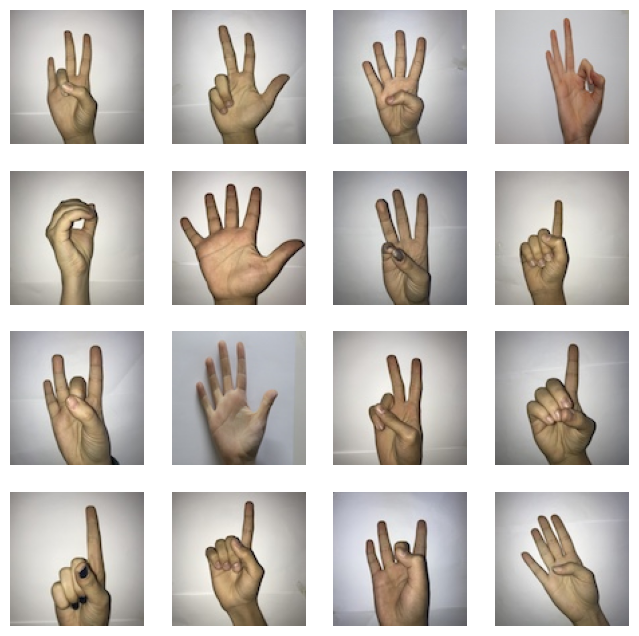

In [7]:
# ploting images from train dir

def plot_images(PATH):
  images = []
  for folder in os.listdir(PATH):
    for image in os.listdir(PATH + '/' + folder):
      images.append(os.path.join(PATH, folder, image))

  plt.figure(1, figsize=(8, 8))

  for i in range(16):
    i += 1
    random_img = random.choice(images)
    imgs = plt.imread(random_img)
    plt.subplot(4, 4,i)
    plt.axis('off')
    plt.imshow(imgs)
  plt.show()

# make sure you are pointing to train dir
PATH = os.getcwd() + '/train'
plot_images(PATH)

In [8]:
# function to create test, train and valid batches
from keras.preprocessing.image import ImageDataGenerator


class FixedImageDataGenerator(ImageDataGenerator):
    def standardize(self, x):
        if self.featurewise_center:
            x = ((x/255.) - 0.5) * 2.
        return x

def create_batches(path):
    train_path = path + '/train' 
    test_path = path + '/test' 
    valid_path = path + '/valid' 

  
    
    train_batches = FixedImageDataGenerator(
        tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
                                                directory=train_path,
                                                target_size=(224,224),
                                                batch_size=10)
    
    
    test_batches = FixedImageDataGenerator(
        tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
                                                directory=test_path,
                                                target_size=(224,224),
                                                shuffle=False,
                                                batch_size=10)
    
    valid_batches = FixedImageDataGenerator(
        tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
                                                        directory=valid_path,
                                                        target_size=(224,224),
                                                        batch_size=10)
    
    return (train_batches,test_batches,valid_batches)

# make sure you are pointing to the dataset dir
PATH = os.getcwd()
train_batches,test_batches,valid_batches = create_batches(PATH)

Found 1212 images belonging to 10 classes.
Found 150 images belonging to 10 classes.
Found 700 images belonging to 10 classes.


#### Building Model

In [9]:
# modifing mobileNet for digit classification
from keras.layers import GlobalAveragePooling2D,Dense
from keras import Model

def create_model():
    model = tf.keras.applications.mobilenet.MobileNet()
    print("Mobile Net Model Summary")
    model.summary()

    x = model.layers[-6].output
    g = GlobalAveragePooling2D()(x)
    output = Dense(units=10,activation='softmax')(g)

    model = Model(inputs=model.input, outputs=output)
    for layer in model.layers[:-35]:
        layer.trainable = False
    print('Modified Model')
    model.summary()

    params = count_params(model)
    assert params['trainable_params'] == 2411530 
    assert params['non_trainable_params'] == 827584
    return model

model = create_model()

Mobile Net Model Summary
Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                

#### Training the Model

In [10]:
# training the model 

from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.optimizers import RMSprop

def model_fit(model,train_batches, valid_batches,epoches =30, optimizer=RMSprop(learning_rate=1e-4)):

    callback = [ReduceLROnPlateau(monitor = 'val_loss', patience = 10, factor=0.25, verbose=1),
                ModelCheckpoint("models/smobilenet.h5",save_best_only=True)]

    model.compile(optimizer=optimizer,
                loss='categorical_crossentropy',
                metrics=['accuracy'])

    history = model.fit(x=train_batches,
            validation_data=valid_batches,
            epochs=epoches,
            verbose=2,
            callbacks=callback)

    if os.path.isfile('models/smobilenet.h5') is False:
        model.save('models/smobilenet.h5')
    return (model,history)

os.chdir('../')
model, history = model_fit(model,train_batches,valid_batches)

Epoch 1/30
122/122 - 47s - loss: 0.6333 - accuracy: 0.8069 - val_loss: 0.4788 - val_accuracy: 0.8157 - lr: 1.0000e-04 - 47s/epoch - 383ms/step
Epoch 2/30
122/122 - 42s - loss: 0.0819 - accuracy: 0.9835 - val_loss: 0.1014 - val_accuracy: 0.9714 - lr: 1.0000e-04 - 42s/epoch - 344ms/step
Epoch 3/30
122/122 - 44s - loss: 0.0269 - accuracy: 0.9959 - val_loss: 0.0544 - val_accuracy: 0.9900 - lr: 1.0000e-04 - 44s/epoch - 364ms/step
Epoch 4/30
122/122 - 45s - loss: 0.0166 - accuracy: 0.9975 - val_loss: 0.0551 - val_accuracy: 0.9814 - lr: 1.0000e-04 - 45s/epoch - 369ms/step
Epoch 5/30
122/122 - 52s - loss: 0.0088 - accuracy: 0.9975 - val_loss: 0.0245 - val_accuracy: 0.9914 - lr: 1.0000e-04 - 52s/epoch - 427ms/step
Epoch 6/30
122/122 - 48s - loss: 0.0077 - accuracy: 0.9983 - val_loss: 0.0310 - val_accuracy: 0.9857 - lr: 1.0000e-04 - 48s/epoch - 396ms/step
Epoch 7/30
122/122 - 46s - loss: 0.0033 - accuracy: 0.9992 - val_loss: 0.0240 - val_accuracy: 0.9914 - lr: 1.0000e-04 - 46s/epoch - 377ms/step

Saving figure mobile_train 


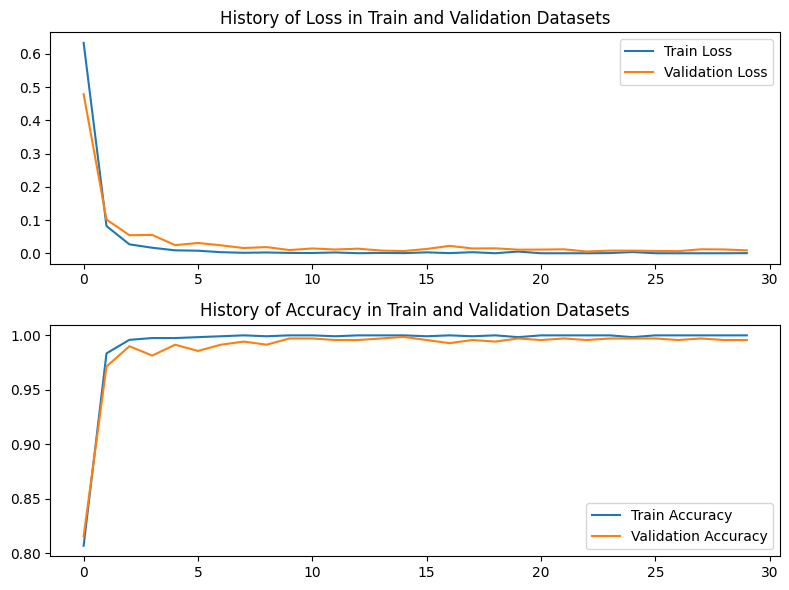

In [11]:
plot_training(history,'mobile_train ')

Saving figure mobile_cm


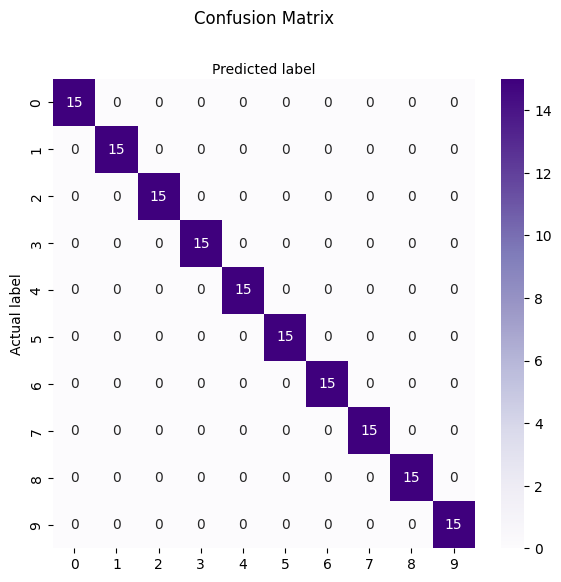

In [12]:
test_labels = test_batches.classes

predictions = model.predict(x=test_batches, verbose=0)

# plot_training()
y_pred=predictions.argmax(axis=1)
plot_confusion(test_labels,y_pred,'mobile_cm')

#### Save Model

In [13]:
# saving model
os.chdir('models')
model.save("mobile_net.h5")